# The Problem Statement:

The sequence identity of the COVID19 protease and that of SARS-CoV is high, hence by using the known SARS-CoV protease drugs generate possible drugs using machine learning methods to generate novel drug like candidates. Use a variational autoencoder with SMILES representation to generate novel molecules from the trained continuous latent space. The novel molecules shall be assessed based on SMART pattern matching, to rule out unlikely molecular structures e.g structures with multiple 3,4,7,8 membered rings, purely acyclic compounds, highly branched ones etc. Furthermore, diversity based on PubChem / MACCS fingerprints (tanimoto coefficients <= 0.60) shall also be assessed to make sure generated structures are significantly dissimilar to training set. Use multiple SARS-CoV-2 protease conformation to screen of generated chemicals using ensemble molecular docking protocol at both allosteric and orthosteric sites. Retain chemicals with best docking scores and binding energies as per the guidelines. Shortlist the top 100 or top 25% (max 100) hits and refine the best 10 using MD simulation without any restraints.

In [144]:
import pandas as pd
import numpy as np
import random

In [145]:
random.seed(24)

In [146]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem

def canonicalize(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles))

def validSMILES(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    return True

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.cluster import KMeans

In [149]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [150]:
USE_CUDA = torch.cuda.is_available() #False on my computer argh

In [255]:
traindata = pd.read_csv('data/trainDILI.csv')

In [256]:
traindata['cleanSMILES'] = traindata['SMILES'].apply(canonicalize)

In [257]:
traindata

,SMILES,Drug_Name,IsDILI,cleanSMILES
0,BrC(Cl)C(F)(F)F,Halothane,1.0,FC(F)(F)C(Cl)Br
1,Br[C@@H](C(C)C)C(=O)NC(=O)N,Bromisoval,1.0,CC(C)[C@H](Br)C(=O)NC(N)=O
2,Brc1[nH]c2c3c1CC1N(CC(C=C1c3ccc2)C(=O)N[C@]1(O...,Bromocriptine,0.0,CC(C)CC1C(=O)N2CCCC2[C@@]2(O)O[C@@](NC(=O)C3C=...
3,Brc1c(nc(nc1Oc1c(cc(cc1C)C#N)C)Nc1ccc(cc1)C#N)N,Etravirine,1.0,Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc(N)c1Br
4,Brc1c2nccnc2ccc1NC=1NCCN=1,Brimonidine,0.0,Brc1c(NC2=NCCN2)ccc2nccnc12
...,...,...,...,...
961,s1cccc1CN(CCN(C)C)c1ncccc1,Methapyrilene,1.0,CN(C)CCN(Cc1cccs1)c1ccccn1
962,s1cccc1C\C(=C/c1n(Cc2ccc(cc2)C(O)=O)c(nc1)CCCC...,Eprosartan,0.0,CCCCc1ncc(/C=C(\Cc2cccs2)C(=O)O)n1Cc1ccc(C(=O)...
963,s1cccc1\C=C\C1=NCCCN1C,Pyrantel,0.0,CN1CCCN=C1/C=C/c1cccs1
964,s1ccnc1NC(=O)C=1N(S(=O)(=O)c2c(cccc2)C=1O)C,Sudoxicam,1.0,CN1C(C(=O)Nc2nccs2)=C(O)c2ccccc2S1(=O)=O


In [258]:
data = list(zip(traindata['cleanSMILES'],traindata['cleanSMILES']))


In [259]:
data

[('FC(F)(F)C(Cl)Br', 'FC(F)(F)C(Cl)Br'),
 ('CC(C)[C@H](Br)C(=O)NC(N)=O', 'CC(C)[C@H](Br)C(=O)NC(N)=O'),
 ('CC(C)CC1C(=O)N2CCCC2[C@@]2(O)O[C@@](NC(=O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12',
  'CC(C)CC1C(=O)N2CCCC2[C@@]2(O)O[C@@](NC(=O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12'),
 ('Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc(N)c1Br',
  'Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc(N)c1Br'),
 ('Brc1c(NC2=NCCN2)ccc2nccnc12', 'Brc1c(NC2=NCCN2)ccc2nccnc12'),
 ('Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21',
  'Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21'),
 ('CCc1oc2ccccc2c1C(=O)c1cc(Br)c(O)c(Br)c1',
  'CCc1oc2ccccc2c1C(=O)c1cc(Br)c(O)c(Br)c1'),
 ('NC(N)=Nc1nc(CSCC/N=C/NS(=O)(=O)c2ccc(Br)cc2)cs1',
  'NC(N)=Nc1nc(CSCC/N=C/NS(=O)(=O)c2ccc(Br)cc2)cs1'),
 ('Nc1c(CC(=O)O)cccc1C(=O)c1ccc(Br)cc1',
  'Nc1c(CC(=O)O)cccc1C(=O)c1ccc(Br)cc1'),
 ('CN(C)CCC(c1ccc(Br)cc1)c1ccccn1', 'CN(C)CCC(c1ccc(Br)cc1)c1ccccn1'),
 ('Brc1ccccc1', 'Brc1ccccc1'),
 ('CCCC1CC(C(=O)NC(C(C)Cl)C2OC(SC

We clean up the similes strings into stuff that can be fed into the LSTM
#use content from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [260]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_chars = 3  # Count SOS and EOS and PAD

    def addSMILES(self, smiles):
        for char in smiles:
            self.addChar(char)

    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

In [262]:
max([len(smiles) for smiles in traindata['cleanSMILES'] ])

293

In [263]:
MIN_LENGTH = 3
MAX_LENGTH = 25

def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs

In [264]:
def prepareData(lang1, lang2, data):
    """takes data as list of pairs for now
    returns the dictionaries for input and output languages, and the pairs"""
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    pairs = data
    print("Read %s smiles pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Filtered to %d pairs" % len(pairs))
    
    print("Counting chars...")
    for pair in pairs:
        input_lang.addSMILES(pair[0])
        output_lang.addSMILES(pair[1])
    print("Counted chars:")
    print(input_lang.name, input_lang.n_chars)
    print(output_lang.name, output_lang.n_chars)
    return input_lang, output_lang, pairs

In [266]:
#input_lang, output_lang, pairs = prepareData("Random SMILES","Canonical SMILES", data)
input_lang, output_lang, pairs = prepareData("Canonical SMILES","Canonical SMILES", data)
print(random.choice(pairs))

Read 966 smiles pairs
Filtered to 143 pairs
Counting chars...
Counted chars:
Canonical SMILES 30
Canonical SMILES 30
('C=CC(N)CCC(=O)O', 'C=CC(N)CCC(=O)O')


In [267]:
len(pairs)

143

In [269]:
testpairs = pairs[100:]

In [270]:
pairs = pairs[0:100]

How do we deal with this problem that the languages are different?

In [271]:
len(pairs)

100

# Model code
Now we implement the seq-to-vec part

In [165]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

In [166]:
class VAE(nn.Module):
    def __init__(self,hidden_size, lat_int_size = 60, lat_size = 30):
        super(VAE, self).__init__()
        self.hidden_size = hidden_size
        self.lat_int_size = lat_int_size
        self.lat_size = lat_size
        self.fc1 = nn.Linear(hidden_size, lat_int_size)
        self.fc21 = nn.Linear(lat_int_size, lat_size)
        self.fc22 = nn.Linear(lat_int_size, lat_size)
        self.fc3 = nn.Linear(lat_size, lat_int_size)
        self.fc4 = nn.Linear(lat_int_size, hidden_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        #mu, logvar = self.encode(x.view(-1, hidden_size))
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [167]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()

        # Keep for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, last_hidden):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        output, hidden = self.gru(embedded, last_hidden)
        output = self.out(output)

        # Return final output, hidden state
        return output, hidden

## Dealing with variable length sequences

In [168]:
def indexesFromSmiles(lang, smiles):
    return [lang.char2index[char] for char in smiles] + [EOS_token]


def tensorFromSmiles(lang, smiles):
    indexes = indexesFromSmiles(lang, smiles)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq


In [202]:
def random_batch(batch_size, whichpairs):
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(whichpairs)
        input_seqs.append(indexesFromSmiles(input_lang, pair[0]))
        target_seqs.append(indexesFromSmiles(output_lang, pair[1]))

    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs) 
    """the * unzips"""
    
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()
        
    return input_var, input_lengths, target_var, target_lengths

In [170]:
def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long() #note arange is [) unlike torch.range which is []
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length))

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """

    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

## Testing the model

In [203]:
small_batch_size = 3
input_batches, input_lengths, target_batches, target_lengths = random_batch(small_batch_size, pairs)

print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([20, 3])
target_batches torch.Size([20, 3])


In [172]:
small_hidden_size = 8
small_n_layers = 1
small_latent_int_size = 10
small_lat_size = 5

encoder_test = EncoderRNN(input_lang.n_chars, small_hidden_size, small_n_layers)
vae_test = VAE(small_hidden_size,small_latent_int_size, small_lat_size)
decoder_test = DecoderRNN(small_hidden_size, output_lang.n_chars, small_n_layers)

if USE_CUDA:
    encoder_test.cuda()
    decoder_test.cuda()
    vae_test.cuda()

In [173]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size()) # n_layers * 2 x batch_size x hidden_size

encoder_outputs torch.Size([21, 3, 8])
encoder_hidden torch.Size([2, 3, 8])


In [174]:
encoder_hidden[:decoder_test.n_layers].shape

torch.Size([1, 3, 8])

In [175]:
new_hidden, mu, logvar = vae_test(encoder_hidden[:decoder_test.n_layers])

print('new_hidden size', new_hidden.size())
print('mu_shape', mu.shape)

new_hidden size torch.Size([1, 3, 8])
mu_shape torch.Size([1, 3, 5])


In [176]:
max_target_length = max(target_lengths)

# Prepare decoder input and outputs
decoder_input = Variable(torch.LongTensor([SOS_token] * small_batch_size))
decoder_hidden = encoder_hidden[:decoder_test.n_layers] # Use last (forward) hidden state from encoder
all_decoder_outputs = Variable(torch.zeros(max_target_length, small_batch_size, decoder_test.output_size))

if USE_CUDA:
    all_decoder_outputs = all_decoder_outputs.cuda()
    decoder_input = decoder_input.cuda()

# Run through decoder one time step at a time
for t in range(max_target_length):
    decoder_output, decoder_hidden = decoder_test(decoder_input, decoder_hidden)
    all_decoder_outputs[t] = decoder_output # Store this step's outputs
    decoder_input = target_batches[t] # Next input is current target

# Test masked cross entropy loss

loss = masked_cross_entropy(all_decoder_outputs.transpose(0, 1).contiguous(),
                            target_batches.transpose(0, 1).contiguous(),
                           target_lengths)
print('loss', loss.item())

loss 3.454841136932373


/home/julian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [177]:
Variable(torch.LongTensor(target_lengths))

tensor([21, 15,  9])

## Evaluation code

In [201]:
def validation_loss(input_batches, input_lengths, target_batches, target_lengths,\
          encoder,vae, decoder, max_length=MAX_LENGTH):
    
    with torch.no_grad():
        val_loss = 0 # Added onto for each word
        # Run words through encoder
        encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
        
        # run hidden vector through vae, also get the mu and logvar
        new_hidden, mu, logvar = vae(encoder_hidden[:decoder.n_layers])

        # Prepare input and output variables
        decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size)).to(device)
        decoder_hidden = new_hidden
        # Use last (forward) hidden state from encoder

        max_target_length = max(target_lengths)
        all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size)).to(device)



        # Run through decoder one time step at a time
        for t in range(max_target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            all_decoder_outputs[t] = decoder_output
            decoder_input = target_batches[t] # Next input is current target (this is teacher forcing?)

        # Loss calculation and backpropagation
        recon_loss = masked_cross_entropy(
            all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
            target_batches.transpose(0, 1).contiguous(), # -> batch x seq
            target_lengths
        )

        #apparently this is the analytical solution for KL divergence of gaussians
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = recon_loss + kl_loss
        return loss.item()


In [178]:
def evaluate(encoder,vae,decoder,input_seq, max_length=MAX_LENGTH):
    input_lengths = [len(input_seq)]
    input_seqs = [indexesFromSmiles(input_lang, input_seq)]
    input_batches = Variable(torch.LongTensor(input_seqs)).transpose(0, 1)
    
    if USE_CUDA:
        input_batches = input_batches.cuda()
        
    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)
    
    # Run through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    #run through vae
    new_hidden, mu, logvar = vae(encoder_hidden[:decoder.n_layers])

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token])) # SOS
    decoder_hidden = new_hidden
    # Use last (forward) hidden state from encoder
    
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_chars = []
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden)

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0].item()
        #print("ni",ni)
        if ni == EOS_token:
            #decoded_chars.append('<EOS>') there's no point adding it, just screws up rdkit
            break
        else:
            decoded_chars.append(output_lang.index2char[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return ''.join(decoded_chars)

In [179]:
def evaluateRandomly(encoder,vae, decoder, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('original smiles', pair[0])
        print('actual canonical SMILES', pair[1])
        output_smiles = evaluate(encoder,vae, decoder, pair[0])
        print('predicted canonical SMILES', output_smiles)
        print('')
        
evaluateRandomly(encoder_test,vae_test,decoder_test)        
evaluate(encoder_test,vae_test,decoder_test,'CCCO')

def quality(encoder,vae,decoder, n=20):
    valids = 0
    for i in range(n):
        pair = random.choice(pairs)
        output_smiles = evaluate(encoder,vae, decoder, pair[0])
        if validSMILES(output_smiles):
            valids +=1
            print('predicted canonical SMILES', output_smiles, 'n: ',i)
    print("Fraction of valid SMILES is: ",valids/n)
        
quality(encoder_test,vae_test, decoder_test)



original smiles OC1COC2C(O)COC12
actual canonical SMILES OC1COC2C(O)COC12
predicted canonical SMILES =========================

original smiles CN(C)CCOc1ccccc1Cc1ccccc1
actual canonical SMILES CN(C)CCOc1ccccc1Cc1ccccc1
predicted canonical SMILES =========================

original smiles C#CCNC1CCc2ccccc21
actual canonical SMILES C#CCNC1CCc2ccccc21
predicted canonical SMILES =========================

original smiles COc1ccc(OC)c(C(O)C(C)N)c1
actual canonical SMILES COc1ccc(OC)c(C(O)C(C)N)c1
predicted canonical SMILES =========================

original smiles CC(C)CC(CN)CC(=O)O
actual canonical SMILES CC(C)CC(CN)CC(=O)O
predicted canonical SMILES =========================



RDKit ERROR: [02:29:06] SMILES Parse Error: syntax error while parsing: =========================
RDKit ERROR: [02:29:07] SMILES Parse Error: Failed parsing SMILES '=========================' for input: '========================='
RDKit ERROR: [02:29:07] SMILES Parse Error: syntax error while parsing: =========================
RDKit ERROR: [02:29:07] SMILES Parse Error: Failed parsing SMILES '=========================' for input: '========================='
RDKit ERROR: [02:29:07] SMILES Parse Error: syntax error while parsing: =========================
RDKit ERROR: [02:29:07] SMILES Parse Error: Failed parsing SMILES '=========================' for input: '========================='
RDKit ERROR: [02:29:07] SMILES Parse Error: syntax error while parsing: =========================
RDKit ERROR: [02:29:07] SMILES Parse Error: Failed parsing SMILES '=========================' for input: '========================='
RDKit ERROR: [02:29:07] SMILES Parse Error: syntax error while parsing: ====

Fraction of valid SMILES is:  0.0


RDKit ERROR: [02:29:07] SMILES Parse Error: syntax error while parsing: =========================
RDKit ERROR: [02:29:07] SMILES Parse Error: Failed parsing SMILES '=========================' for input: '========================='


In [180]:
output_lang.index2char

{0: 'PAD',
 1: 'SOS',
 2: 'EOS',
 3: 'F',
 4: 'C',
 5: '(',
 6: ')',
 7: 'l',
 8: 'B',
 9: 'r',
 10: 'c',
 11: '1',
 12: 'O',
 13: 'N',
 14: '=',
 15: 'P',
 16: '[',
 17: 'n',
 18: 'H',
 19: ']',
 20: '2',
 21: 'o',
 22: 's',
 23: '#',
 24: '@',
 25: '3',
 26: '+',
 27: '-',
 28: 'S',
 29: '/'}

## Training code

In [181]:
def train(input_batches, input_lengths, target_batches, target_lengths,\
          encoder,vae, decoder, encoder_optimizer,vae_optimizer, decoder_optimizer,\
          max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    vae_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # run hidden vector through vae, also get the mu and logvar
    new_hidden, mu, logvar = vae(encoder_hidden[:decoder.n_layers])
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = new_hidden
    # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target (this is teacher forcing?)

    # Loss calculation and backpropagation
    recon_loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    
    #apparently this is the analytical solution for KL divergence of gaussians
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    loss = recon_loss + kl_loss
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    vc = torch.nn.utils.clip_grad_norm_(vae.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    
    # Update parameters with optimizers
    encoder_optimizer.step()
    vae_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()


In [182]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Actual training

## Loading a saved model

In [313]:
# Configure models
hidden_size = 512
lat_int_size = 400
lat_size = 200
n_layers = 1

encoder = EncoderRNN(input_lang.n_chars, hidden_size, n_layers=1).to(device)
vae = VAE(hidden_size, lat_int_size, lat_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_chars, n_layers=1).to(device)

from pathlib import Path
savedencoderfile = "SMILESencoder50.pt"
savedvaefile = "SMILESvae50.pt"
saveddecoderfile = "SMILESdecoder50.pt"
if Path(savedencoderfile).is_file():
    # file exists
    encoder.load_state_dict(torch.load(savedencoderfile))
    #model.eval() wtf is this
    print("=== Encoder was loaded from " + savedencoderfile)
    
if Path(savedvaefile).is_file():
    # file exists
    vae.load_state_dict(torch.load(savedvaefile))
    #model.eval() wtf is this
    print("=== Encoder was loaded from " + savedvaefile)
    
if Path(saveddecoderfile).is_file():
    # file exists
    decoder.load_state_dict(torch.load(saveddecoderfile))
    #model.eval() wtf is this
    print("=== Decoder was loaded from " + saveddecoderfile)

    

In [314]:
evaluate(encoder,vae, decoder, 'CCCOC')

'[11'

In [315]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.001
decoder_learning_ratio = 5.0


plot_every = 100
print_every = 100
n_epochs = 1000

batch_size = 50

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
vae_optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

In [316]:
# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
test_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every
epoch = 0
while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size, pairs)

    # Run the train function
    loss= train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder,vae, decoder,
        encoder_optimizer,vae_optimizer, decoder_optimizer
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    
    #job.record(epoch, loss)

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),\
                                               epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size, testpairs)
        test_loss = validation_loss(input_batches, input_lengths, target_batches, target_lengths,\
                                    encoder,vae, decoder)
        test_losses.append(test_loss)

/home/julian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1m 52s (- 16m 49s) (100 10%) 2.2043
3m 38s (- 14m 35s) (200 20%) 0.3228
5m 27s (- 12m 43s) (300 30%) 0.2905
7m 24s (- 11m 6s) (400 40%) 0.2818
9m 12s (- 9m 12s) (500 50%) 0.2720
10m 59s (- 7m 19s) (600 60%) 0.2710
12m 47s (- 5m 28s) (700 70%) 0.2705
14m 36s (- 3m 39s) (800 80%) 0.2673
16m 25s (- 1m 49s) (900 90%) 0.2619
18m 13s (- 0m 0s) (1000 100%) 0.2724


In [317]:
evaluateRandomly(encoder,vae,decoder)

original smiles O=C(O)O
actual canonical SMILES O=C(O)O
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O

original smiles CC(O)C(=O)O
actual canonical SMILES CC(O)C(=O)O
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O

original smiles CC(N)Cc1ccccc1
actual canonical SMILES CC(N)Cc1ccccc1
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O

original smiles COC(F)(F)C(Cl)Cl
actual canonical SMILES COC(F)(F)C(Cl)Cl
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O

original smiles O=C(O)CCCCCCCC(=O)O
actual canonical SMILES O=C(O)CCCCCCCC(=O)O
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O



<Figure size 432x288 with 0 Axes>

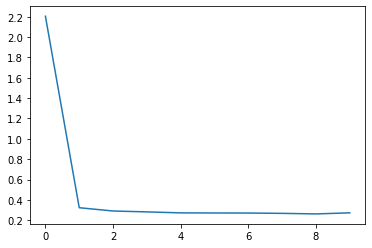

<Figure size 432x288 with 0 Axes>

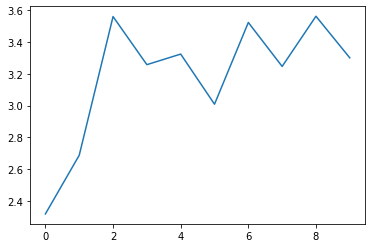

In [318]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)
show_plot(test_losses)

In [319]:
evaluate(encoder,vae, decoder, "CCCO")

'CC(=O)Oc1ccccc1C(=O)O'

In [320]:
quality(encoder,vae,decoder, 50)

predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  0
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  1
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  2
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  3
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  4
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  5
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  6
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  7
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  8
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  9
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  10
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  11
predicted canonical SMILES CN(C)N=Nc1[nH]cnc1C(N)=O n:  12
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  13
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  14
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  15
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  16
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  17

In [321]:
def trainedpics(encoder,vae,decoder,n=10):
    ms = []
    for i in range(n):
        pair = random.choice(pairs)
        output_smiles = evaluate(encoder,vae, decoder, pair[0])
        if validSMILES(output_smiles):
            ms.append(Chem.MolFromSmiles(output_smiles))
            print('predicted canonical SMILES', output_smiles, 'n: ',i)
    return ms


    

predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  0
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  1
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  2
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  3
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  4
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  5
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  6
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  7
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  8
predicted canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  9


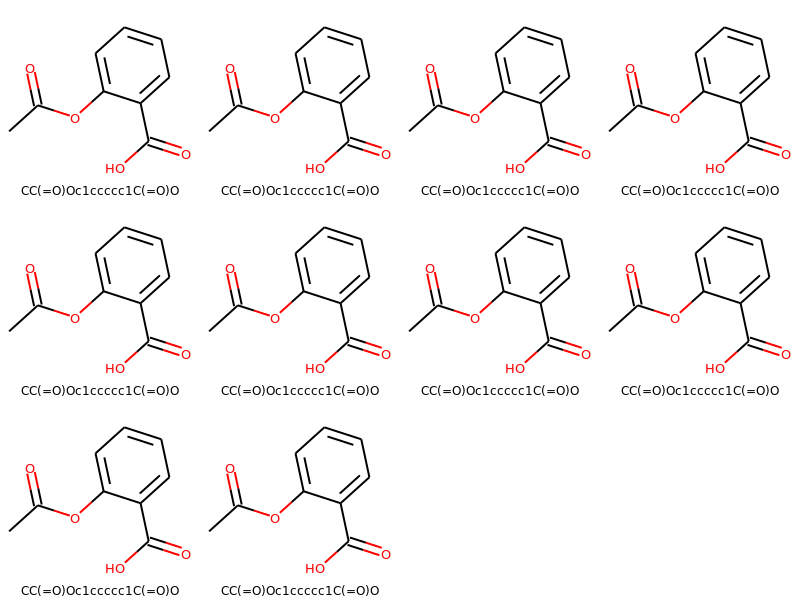

In [322]:
ms = trainedpics(encoder,vae,decoder)
Draw.MolsToGridImage(ms,molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms])

# Saving the model

In [323]:
torch.save(encoder.state_dict(), savedencoderfile)
torch.save(vae.state_dict(), savedvaefile)
torch.save(decoder.state_dict(), saveddecoderfile)
print("Model was saved as ",savedencoderfile, "and",savedvaefile,"and", saveddecoderfile )

Model was saved as  SMILESencoder50.pt and SMILESvae50.pt and SMILESdecoder50.pt


# Sampling from the model

In [324]:
def randomSample(vae,decoder):
    #get random hidden vector from the p(x/z) distribution
    new_hidden = vae.decode(torch.randn(1,1,vae.lat_size).to(device))
    
    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token])) # SOS
    decoder_hidden = new_hidden
    # Use last (forward) hidden state from encoder
    
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_chars = []
    
    # Run through decoder
    for di in range(MAX_LENGTH):
        decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden)

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0].item()
        #print("ni",ni)
        if ni == EOS_token:
            #decoded_chars.append('<EOS>') there's no point adding it, just screws up rdkit
            break
        else:
            decoded_chars.append(output_lang.index2char[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return ''.join(decoded_chars)

def samplepics(encoder,vae,decoder,n=10):
    ms = []
    for i in range(n):
        output_smiles = randomSample(vae,decoder)
        if validSMILES(output_smiles):
            ms.append(Chem.MolFromSmiles(output_smiles))
            print('generated canonical SMILES', output_smiles, 'n: ',i)
    return ms

generated canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  0
generated canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  1
generated canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  2
generated canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  3
generated canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  4
generated canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  5
generated canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  6
generated canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  7
generated canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  8
generated canonical SMILES CC(=O)Oc1ccccc1C(=O)O n:  9


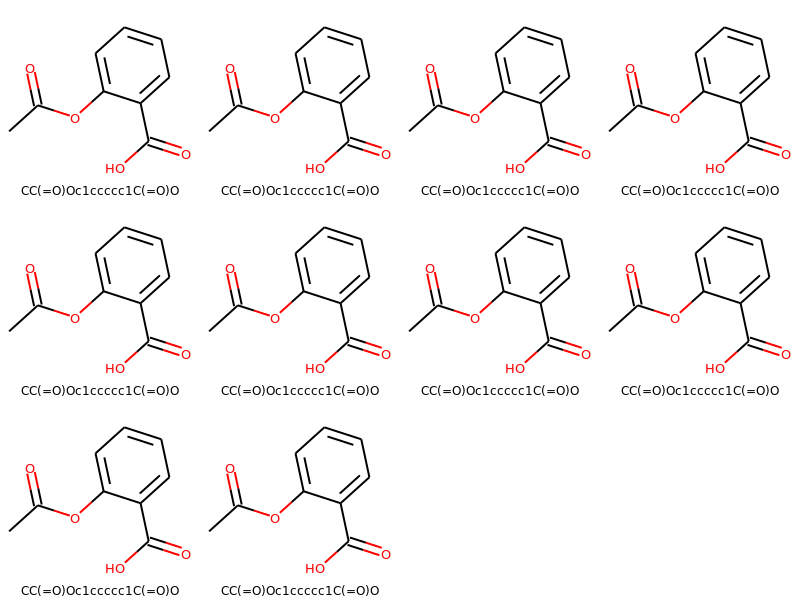

In [325]:
ms = samplepics(encoder,vae,decoder)
Draw.MolsToGridImage(ms,molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms])

# References

https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

In [134]:
if __name__ == "__main__":
    pass
    # do trained scripty stuff